# Notebook 02: Bayesian Price Elasticity Modeling

## Quantifying How Demand Responds to Price Changes

**Central Question**: *"If we increase the price by 10%, how much does demand decrease?"*

This is the fundamental question for any pricing strategy. The answer—**price elasticity of demand**—determines optimal pricing.

---

### What is Price Elasticity?

$$\epsilon = \frac{\% \Delta Q}{\% \Delta P} = \frac{\partial \log Q}{\partial \log P}$$

- **ε = -1**: Unit elastic (10% price increase → 10% demand decrease)
- **ε > -1** (e.g., -0.5): Inelastic (demand insensitive to price)
- **ε < -1** (e.g., -2): Elastic (demand very sensitive to price)

For ride-sharing, research suggests elasticity typically ranges from **-0.5 to -2.0** depending on context.

### Why Bayesian?

1. **Uncertainty quantification**: We get a full posterior distribution, not just a point estimate
2. **Prior knowledge**: We can incorporate economic theory (elasticity is likely negative)
3. **Hierarchical modeling**: Natural for segmented analysis
4. **Small sample robustness**: Priors regularize estimates in sparse segments

---

## Setup

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Bayesian imports
import pymc as pm
import arviz as az

# Project imports
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from data.loader import load_merged_data
from visualization.plots import set_publication_style, PALETTE

# Settings
set_publication_style()
az.style.use('arviz-darkgrid')

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

PyMC version: 5.25.1
ArviZ version: 0.23.0


## 1. Load and Prepare Data

In [2]:
# Load processed data from notebook 01
df = load_merged_data()
print(f"Loaded {len(df):,} rides")
df.head()

Loaded 637,976 rides


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,is_rush_hour,time_of_day,price_per_mile,temp,clouds,pressure,rain,humidity,wind,route
0,3.03,Lyft,2018-11-26 03:40:46.318,Theatre District,Boston University,34.0,1.0,ef4771c2-c88d-4730-aaf7-a95751e9d27e,lyft_luxsuv,Lux Black XL,...,False,night,11.221122,41.07,0.86,1014.39,NaN,0.92,1.36,Boston University → Theatre District
1,1.30,Uber,2018-11-26 03:40:46.319,Theatre District,South Station,18.5,1.0,00ea74ea-2c49-416c-bfc5-f7877025f6eb,6c84fd89-3f11-4782-9b50-97c468b19529,Black,...,False,night,14.230769,40.86,0.87,1014.39,NaN,0.93,1.60,South Station → Theatre District
2,2.71,Uber,2018-11-26 03:40:46.320,Fenway,Theatre District,19.5,1.0,8682f9bf-5cc0-4dfc-b8fe-4e22070d1684,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,...,False,night,7.195572,40.80,0.87,1014.39,NaN,0.93,1.55,Theatre District → Fenway
3,2.71,Uber,2018-11-26 03:40:46.320,Fenway,Theatre District,32.0,1.0,6172077a-22de-481b-aae2-b5763c87a6c4,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,...,False,night,11.808118,40.80,0.87,1014.39,NaN,0.93,1.55,Theatre District → Fenway
4,2.43,Lyft,2018-11-26 03:40:46.320,Beacon Hill,Northeastern University,10.5,1.0,edfc7f44-97e1-48cd-930c-e4fe20e88ac8,lyft,Lyft,...,False,night,4.320988,40.81,0.89,1014.35,NaN,0.93,1.36,Northeastern University → Beacon Hill


### The Endogeneity Problem

**Critical Issue**: In observational data, price is not randomly assigned. Surge pricing is triggered *because* of high demand. This creates reverse causality:

- High demand → triggers surge → we observe high prices with high demand
- This biases elasticity estimates toward zero (or even positive!)

**Our Approach**: 
1. Use surge multiplier as the price variation (exogenous to individual ride decisions)
2. Control for confounders (time, location, weather)
3. Focus on *within-context* variation
4. Acknowledge limitations in interpretation

In [3]:
# Create demand proxy: number of rides per time-location bucket
# This is imperfect but gives us variation in quantity

# Aggregate rides by hour, location, and cab type
demand_df = df.groupby(
    ['time_stamp', 'source', 'cab_type', 'name']
).agg({
    'id': 'count',  # Number of rides = demand proxy
    'price': 'mean',
    'surge_multiplier': 'mean',
    'distance': 'mean',
    'is_rush_hour': 'first',
    'is_weekend': 'first',
    'hour': 'first',
    'temp': 'mean',
    'rain': 'mean',
}).reset_index()

demand_df.columns = ['timestamp', 'location', 'cab_type', 'service', 'ride_count', 
                     'avg_price', 'avg_surge', 'avg_distance', 'is_rush_hour', 
                     'is_weekend', 'hour', 'temp', 'rain']

# Filter to meaningful observations
demand_df = demand_df[demand_df['ride_count'] >= 1].copy()

print(f"Aggregated to {len(demand_df):,} observations")
demand_df.describe()

Aggregated to 631,605 observations


,timestamp,ride_count,avg_price,avg_surge,avg_distance,hour,temp,rain
count,631605,631605.000000,631605.000000,631605.000000,631605.000000,631605.000000,631605.000000,92549.000000
mean,2018-12-05 21:37:13.985049344,1.010087,16.546341,1.015078,2.189365,11.617813,39.206058,0.046039
min,2018-11-26 03:40:46.318000,1.000000,2.500000,1.000000,0.020000,0.000000,19.620000,0.000200
25%,2018-11-28 22:28:45.308999936,1.000000,9.000000,1.000000,1.280000,6.000000,36.160000,0.004000
50%,2018-12-02 07:57:59.510000128,1.000000,13.500000,1.000000,2.160000,12.000000,40.090000,0.012900
75%,2018-12-14 22:45:09.433999872,1.000000,22.500000,1.000000,2.930000,18.000000,43.710000,0.035400
max,2018-12-18 19:15:10.943000,3.000000,97.500000,3.000000,7.860000,23.000000,55.410000,0.780700
std,NaN,0.100432,9.320467,0.095288,1.133257,6.948143,6.606385,0.093791


In [4]:
# Create log variables for elasticity estimation
demand_df['log_quantity'] = np.log(demand_df['ride_count'])
demand_df['log_price'] = np.log(demand_df['avg_price'])
demand_df['log_surge'] = np.log(demand_df['avg_surge'])
demand_df['log_distance'] = np.log(demand_df['avg_distance'])

# Handle any infinities from log(0)
demand_df = demand_df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=['log_quantity', 'log_price', 'log_surge']
)

print(f"After log transformation: {len(demand_df):,} observations")

After log transformation: 631,605 observations


### Visual Exploration: Price-Quantity Relationship

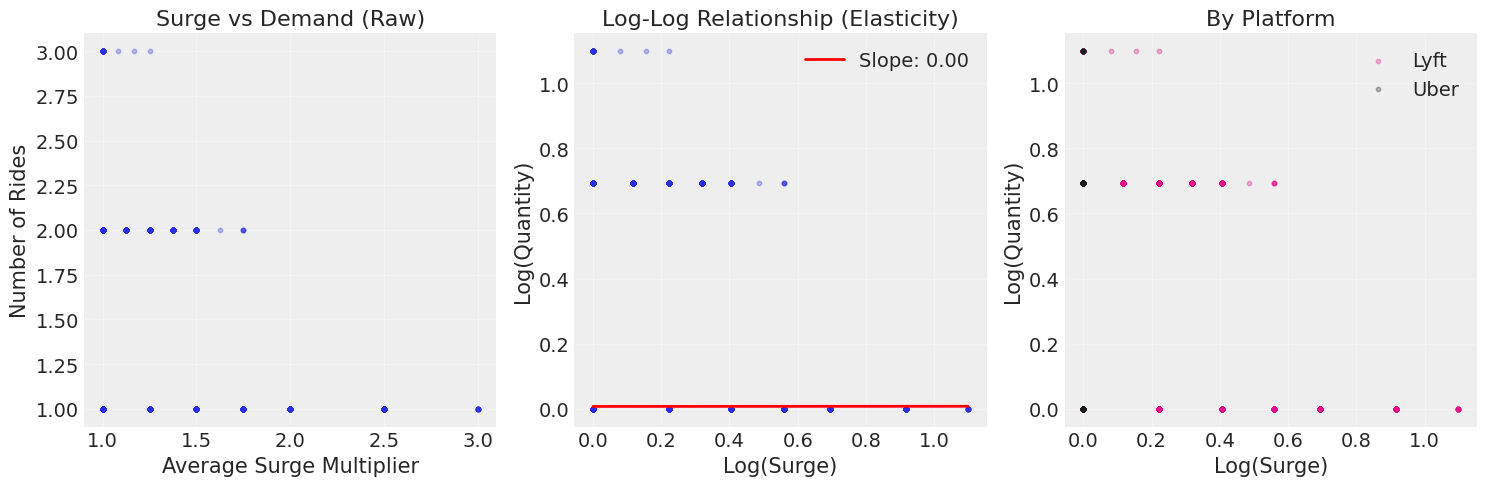


Naive OLS elasticity estimate: 0.000


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Surge vs Quantity
ax = axes[0]
ax.scatter(demand_df['avg_surge'], demand_df['ride_count'], alpha=0.3, s=10)
ax.set_xlabel('Average Surge Multiplier')
ax.set_ylabel('Number of Rides')
ax.set_title('Surge vs Demand (Raw)')

# Log-Log relationship
ax = axes[1]
ax.scatter(demand_df['log_surge'], demand_df['log_quantity'], alpha=0.3, s=10)
z = np.polyfit(demand_df['log_surge'], demand_df['log_quantity'], 1)
p = np.poly1d(z)
x_line = np.linspace(demand_df['log_surge'].min(), demand_df['log_surge'].max(), 100)
ax.plot(x_line, p(x_line), 'r-', linewidth=2, label=f'Slope: {z[0]:.2f}')
ax.set_xlabel('Log(Surge)')
ax.set_ylabel('Log(Quantity)')
ax.set_title('Log-Log Relationship (Elasticity)')
ax.legend()

# By cab type
ax = axes[2]
for cab_type in demand_df['cab_type'].unique():
    subset = demand_df[demand_df['cab_type'] == cab_type]
    color = PALETTE['uber'] if 'uber' in cab_type.lower() else PALETTE['lyft']
    ax.scatter(subset['log_surge'], subset['log_quantity'], alpha=0.3, s=10, 
               label=cab_type, color=color)
ax.set_xlabel('Log(Surge)')
ax.set_ylabel('Log(Quantity)')
ax.set_title('By Platform')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nNaive OLS elasticity estimate: {z[0]:.3f}")

## 2. Bayesian Elasticity Model

### Model Specification

We'll estimate:

$$\log(Q_i) = \alpha + \beta \cdot \log(Surge_i) + \gamma \cdot X_i + \epsilon_i$$

Where:
- $\beta$ is the **price elasticity** (our main parameter of interest)
- $X_i$ are control variables (distance, time, weather)
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$

**Prior choices**:
- $\beta \sim \mathcal{N}(-1, 0.5)$: Centered on unit elasticity, allows range from ~0 to -2
- This incorporates economic theory that demand should decrease with price

In [6]:
# Prepare data for modeling
# Standardize continuous predictors for better sampling
def standardize(x):
    return (x - x.mean()) / x.std()

model_data = demand_df.copy()
model_data['log_surge_std'] = standardize(model_data['log_surge'])
model_data['log_distance_std'] = standardize(model_data['log_distance'])
model_data['hour_std'] = standardize(model_data['hour'])

# Sample for faster iteration (full model later)
sample_size = min(5000, len(model_data))
model_sample = model_data.sample(sample_size, random_state=RANDOM_SEED)

print(f"Using {len(model_sample):,} observations for initial model")

Using 5,000 observations for initial model


In [7]:
# Simple elasticity model
with pm.Model() as simple_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    beta_surge = pm.Normal('beta_surge', mu=-1, sigma=0.5)  # Elasticity prior
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value
    mu = alpha + beta_surge * model_sample['log_surge_std'].values
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=model_sample['log_quantity'].values)
    
    # Sample
    trace_simple = pm.sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED,
                             return_inferencedata=True, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_surge, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
# Model diagnostics
az.summary(trace_simple, var_names=['alpha', 'beta_surge', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.001,0.004,0.008,0.0,0.0,5623.0,3097.0,1.0
beta_surge,-0.001,0.001,-0.002,0.001,0.0,0.0,6231.0,3197.0,1.0
sigma,0.065,0.001,0.063,0.066,0.0,0.0,5673.0,3080.0,1.0


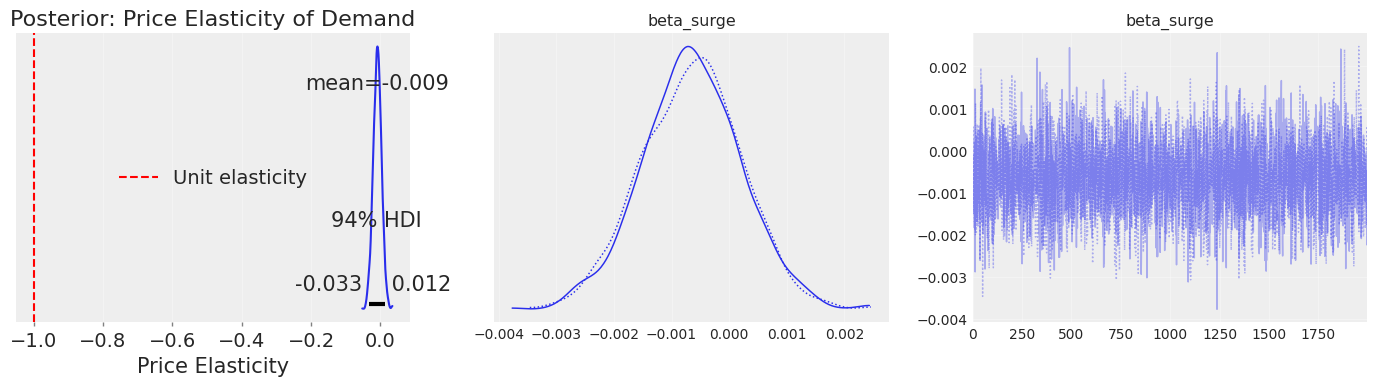


Elasticity estimate (original scale):
  Mean: -0.009
  94% HDI: [-0.032, 0.013]


In [9]:
# Visualize posterior
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Elasticity posterior
ax = axes[0]
beta_samples = trace_simple.posterior['beta_surge'].values.flatten()
# Convert from standardized to original scale
beta_original = beta_samples / model_data['log_surge'].std()
az.plot_posterior(beta_original, ax=ax, hdi_prob=0.94, point_estimate='mean')
ax.axvline(x=-1, color='red', linestyle='--', label='Unit elasticity')
ax.set_xlabel('Price Elasticity')
ax.set_title('Posterior: Price Elasticity of Demand')
ax.legend()

# Trace plot
az.plot_trace(trace_simple, var_names=['beta_surge'], axes=axes[1:3].reshape(1, 2))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nElasticity estimate (original scale):")
print(f"  Mean: {beta_original.mean():.3f}")
print(f"  94% HDI: [{np.percentile(beta_original, 3):.3f}, {np.percentile(beta_original, 97):.3f}]")

## 3. Full Model with Controls

To get a more reliable elasticity estimate, we need to control for confounders.

In [10]:
# Prepare categorical variables
model_sample['is_uber'] = (model_sample['cab_type'] == 'Uber').astype(int)
model_sample['rush_hour_int'] = model_sample['is_rush_hour'].astype(int)
model_sample['weekend_int'] = model_sample['is_weekend'].astype(int)

# Fill missing weather with median
model_sample['temp_std'] = standardize(model_sample['temp'].fillna(model_sample['temp'].median()))
model_sample['rain_binary'] = (model_sample['rain'].fillna(0) > 0).astype(int)

In [11]:
# Full model with controls
with pm.Model() as full_model:
    # Data
    log_surge = pm.Data('log_surge', model_sample['log_surge_std'].values)
    log_distance = pm.Data('log_distance', model_sample['log_distance_std'].values)
    is_uber = pm.Data('is_uber', model_sample['is_uber'].values)
    rush_hour = pm.Data('rush_hour', model_sample['rush_hour_int'].values)
    weekend = pm.Data('weekend', model_sample['weekend_int'].values)
    rain = pm.Data('rain', model_sample['rain_binary'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    
    # Main effect: elasticity
    beta_surge = pm.Normal('beta_surge', mu=-1, sigma=0.5)
    
    # Control coefficients
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    beta_uber = pm.Normal('beta_uber', mu=0, sigma=1)
    beta_rush = pm.Normal('beta_rush', mu=0, sigma=1)
    beta_weekend = pm.Normal('beta_weekend', mu=0, sigma=1)
    beta_rain = pm.Normal('beta_rain', mu=0, sigma=1)
    
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Expected value
    mu = (alpha + 
          beta_surge * log_surge +
          beta_distance * log_distance +
          beta_uber * is_uber +
          beta_rush * rush_hour +
          beta_weekend * weekend +
          beta_rain * rain)
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=model_sample['log_quantity'].values)
    
    # Sample
    trace_full = pm.sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED,
                           return_inferencedata=True, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_surge, beta_distance, beta_uber, beta_rush, beta_weekend, beta_rain, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
# Model summary
az.summary(trace_full, var_names=['alpha', 'beta_surge', 'beta_distance', 
                                   'beta_uber', 'beta_rush', 'beta_weekend', 
                                   'beta_rain', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.004,0.002,0.001,0.007,0.0,0.0,3922.0,2965.0,1.0
beta_surge,-0.000,0.001,-0.002,0.001,0.0,0.0,6567.0,3537.0,1.0
beta_distance,0.000,0.001,-0.001,0.002,0.0,0.0,7482.0,3436.0,1.0
beta_uber,0.002,0.002,-0.002,0.005,0.0,0.0,5308.0,2769.0,1.0
beta_rush,-0.001,0.003,-0.006,0.003,0.0,0.0,5539.0,3449.0,1.0
beta_weekend,0.003,0.002,-0.001,0.007,0.0,0.0,4731.0,3046.0,1.0
beta_rain,0.002,0.003,-0.003,0.007,0.0,0.0,6558.0,2772.0,1.0
sigma,0.065,0.001,0.063,0.066,0.0,0.0,7137.0,3282.0,1.0


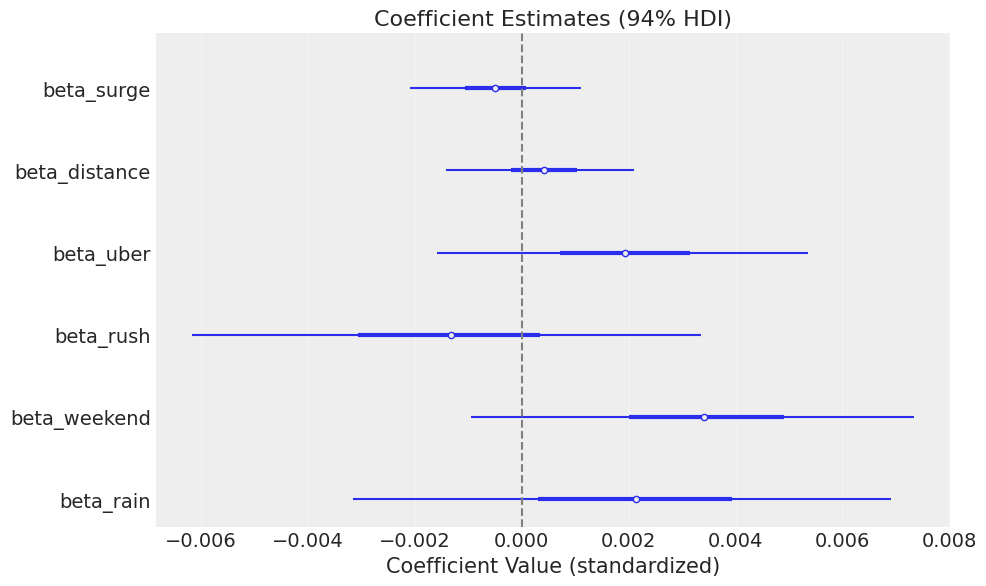

In [13]:
# Visualize all coefficients
fig, ax = plt.subplots(figsize=(10, 6))

az.plot_forest(
    trace_full,
    var_names=['beta_surge', 'beta_distance', 'beta_uber', 
               'beta_rush', 'beta_weekend', 'beta_rain'],
    combined=True,
    hdi_prob=0.94,
    ax=ax
)
ax.axvline(x=0, color='gray', linestyle='--')
ax.set_title('Coefficient Estimates (94% HDI)')
ax.set_xlabel('Coefficient Value (standardized)')

plt.tight_layout()
plt.show()

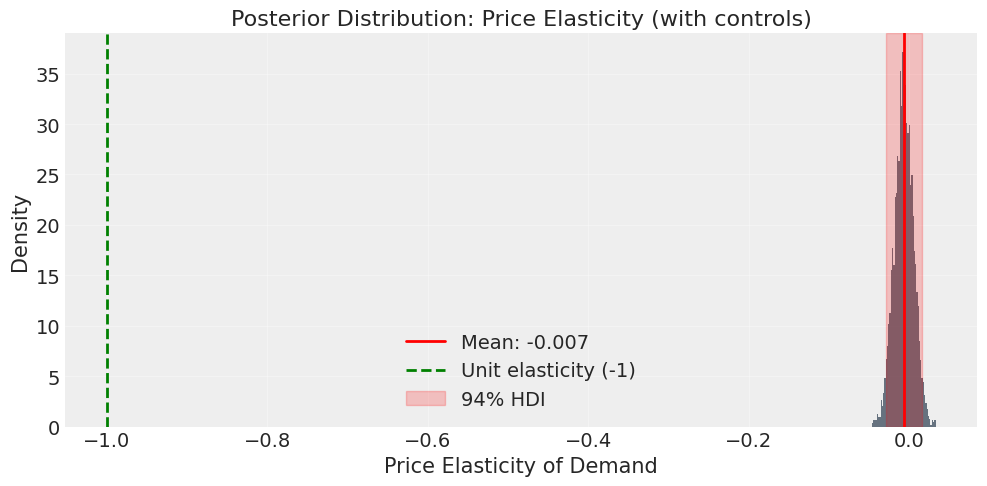


ELASTICITY INTERPRETATION

Estimated elasticity: -0.007
94% credible interval: [-0.029, 0.016]

Interpretation:
  A 10% increase in surge multiplier leads to approximately
  a 0.1% decrease in demand.


In [14]:
# Convert elasticity to original scale and interpret
beta_surge_samples = trace_full.posterior['beta_surge'].values.flatten()
elasticity_original = beta_surge_samples / model_data['log_surge'].std()

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(elasticity_original, bins=50, density=True, alpha=0.7, color=PALETTE['primary'])
ax.axvline(x=elasticity_original.mean(), color='red', linewidth=2, label=f'Mean: {elasticity_original.mean():.3f}')
ax.axvline(x=-1, color='green', linestyle='--', linewidth=2, label='Unit elasticity (-1)')
ax.axvspan(np.percentile(elasticity_original, 3), np.percentile(elasticity_original, 97), 
           alpha=0.2, color='red', label='94% HDI')

ax.set_xlabel('Price Elasticity of Demand')
ax.set_ylabel('Density')
ax.set_title('Posterior Distribution: Price Elasticity (with controls)')
ax.legend()

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ELASTICITY INTERPRETATION")
print("="*50)
print(f"\nEstimated elasticity: {elasticity_original.mean():.3f}")
print(f"94% credible interval: [{np.percentile(elasticity_original, 3):.3f}, {np.percentile(elasticity_original, 97):.3f}]")
print(f"\nInterpretation:")
print(f"  A 10% increase in surge multiplier leads to approximately")
print(f"  a {abs(elasticity_original.mean() * 10):.1f}% decrease in demand.")

## 4. Segmented Elasticity Analysis

Elasticity likely varies by context. Let's estimate separate elasticities for:
- Uber vs Lyft
- Rush hour vs non-rush hour
- Rain vs no rain

In [15]:
# Interaction model for segmented elasticity
with pm.Model() as interaction_model:
    # Data
    log_surge = model_sample['log_surge_std'].values
    is_uber = model_sample['is_uber'].values
    rush_hour = model_sample['rush_hour_int'].values
    rain = model_sample['rain_binary'].values
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    
    # Base elasticity
    beta_surge_base = pm.Normal('beta_surge_base', mu=-1, sigma=0.5)
    
    # Interaction terms (how elasticity changes in each context)
    beta_surge_uber = pm.Normal('beta_surge_x_uber', mu=0, sigma=0.3)
    beta_surge_rush = pm.Normal('beta_surge_x_rush', mu=0, sigma=0.3)
    beta_surge_rain = pm.Normal('beta_surge_x_rain', mu=0, sigma=0.3)
    
    # Main effects
    beta_uber = pm.Normal('beta_uber', mu=0, sigma=1)
    beta_rush = pm.Normal('beta_rush', mu=0, sigma=1)
    beta_rain = pm.Normal('beta_rain', mu=0, sigma=1)
    
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Effective elasticity varies by context
    effective_elasticity = (beta_surge_base + 
                           beta_surge_uber * is_uber +
                           beta_surge_rush * rush_hour +
                           beta_surge_rain * rain)
    
    # Expected value
    mu = (alpha + 
          effective_elasticity * log_surge +
          beta_uber * is_uber +
          beta_rush * rush_hour +
          beta_rain * rain)
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=model_sample['log_quantity'].values)
    
    # Sample
    trace_interaction = pm.sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED,
                                   return_inferencedata=True, progressbar=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta_surge_base, beta_surge_x_uber, beta_surge_x_rush, beta_surge_x_rain, beta_uber, beta_rush, beta_rain, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 60 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [16]:
# Compute segmented elasticities
scale = model_data['log_surge'].std()

base = trace_interaction.posterior['beta_surge_base'].values.flatten() / scale
uber_effect = trace_interaction.posterior['beta_surge_x_uber'].values.flatten() / scale
rush_effect = trace_interaction.posterior['beta_surge_x_rush'].values.flatten() / scale
rain_effect = trace_interaction.posterior['beta_surge_x_rain'].values.flatten() / scale

# Elasticity in each segment
elasticity_lyft_normal = base  # Base case: Lyft, non-rush, no rain
elasticity_uber_normal = base + uber_effect
elasticity_lyft_rush = base + rush_effect
elasticity_uber_rush = base + uber_effect + rush_effect
elasticity_rain = base + rain_effect

# Summary table
segments = {
    'Lyft (normal)': elasticity_lyft_normal,
    'Uber (normal)': elasticity_uber_normal,
    'Lyft (rush hour)': elasticity_lyft_rush,
    'Uber (rush hour)': elasticity_uber_rush,
    'During rain': elasticity_rain,
}

print("\n" + "="*60)
print("SEGMENTED ELASTICITY ESTIMATES")
print("="*60)
print(f"{'Segment':<25} {'Mean':>10} {'94% HDI':>20}")
print("-"*60)
for name, samples in segments.items():
    mean = samples.mean()
    hdi_low, hdi_high = np.percentile(samples, [3, 97])
    print(f"{name:<25} {mean:>10.3f} [{hdi_low:>8.3f}, {hdi_high:>8.3f}]")


SEGMENTED ELASTICITY ESTIMATES
Segment                         Mean              94% HDI
------------------------------------------------------------
Lyft (normal)                 -0.011 [  -0.039,    0.015]
Uber (normal)                  0.048 [  -8.099,    7.890]
Lyft (rush hour)              -0.009 [  -0.075,    0.057]
Uber (rush hour)               0.051 [  -8.111,    7.896]
During rain                    0.034 [  -0.034,    0.106]


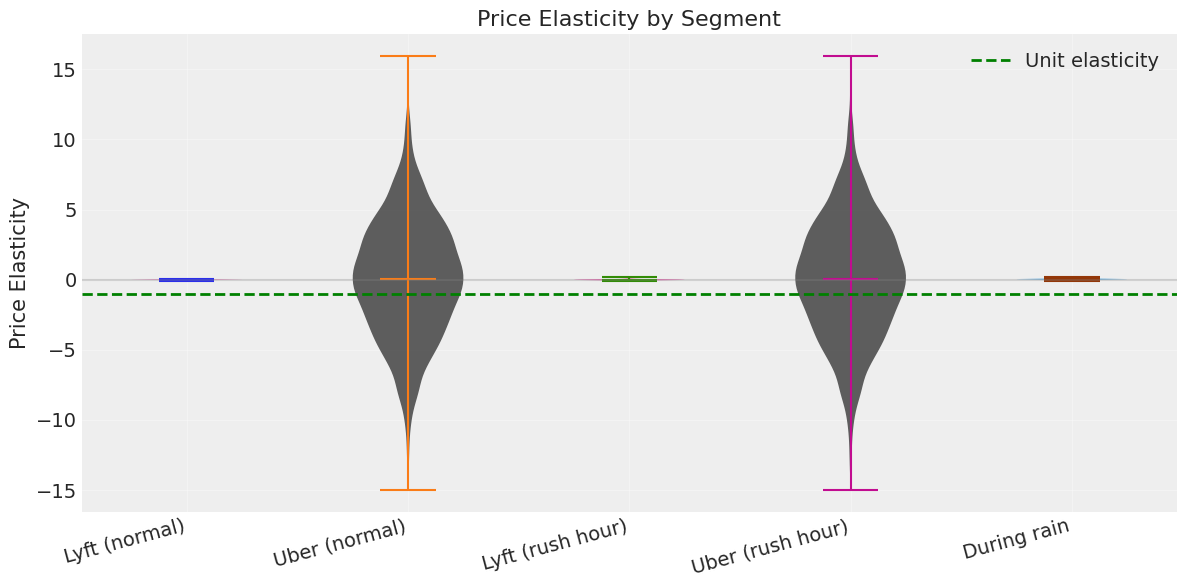

In [17]:
# Visualize segmented elasticities
fig, ax = plt.subplots(figsize=(12, 6))

positions = range(len(segments))
colors = [PALETTE['lyft'], PALETTE['uber'], PALETTE['lyft'], PALETTE['uber'], PALETTE['accent']]

for i, (name, samples) in enumerate(segments.items()):
    parts = ax.violinplot([samples], positions=[i], showmeans=True, showmedians=False)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)

ax.axhline(y=-1, color='green', linestyle='--', linewidth=2, label='Unit elasticity')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

ax.set_xticks(positions)
ax.set_xticklabels(segments.keys(), rotation=15, ha='right')
ax.set_ylabel('Price Elasticity')
ax.set_title('Price Elasticity by Segment')
ax.legend()

plt.tight_layout()
plt.show()

## 5. Business Implications

### Demand Curve Visualization

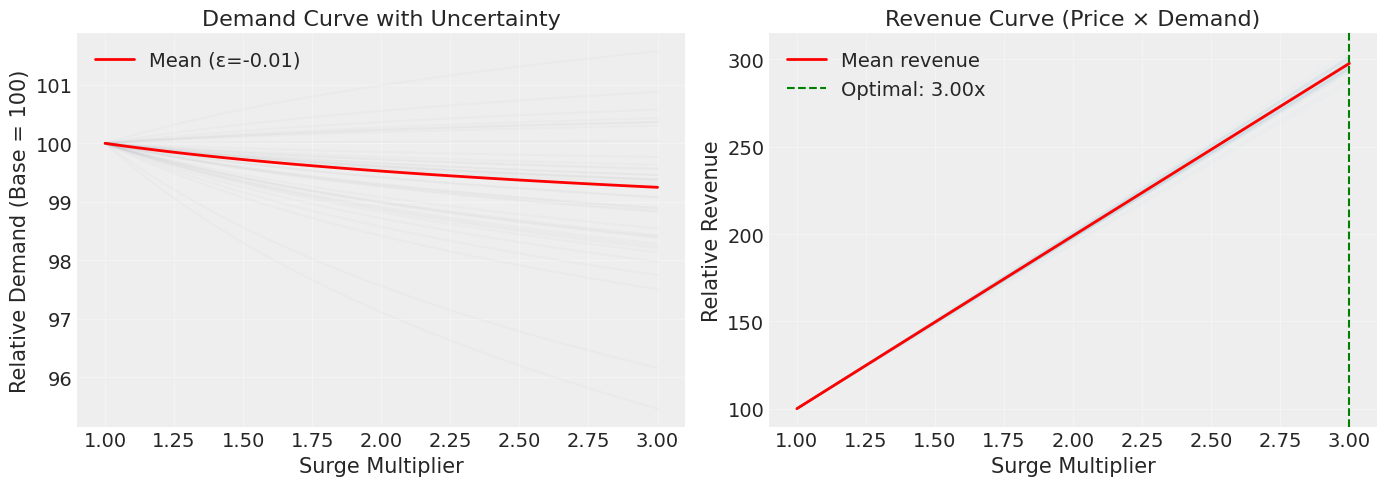


Optimal surge multiplier (based on mean elasticity): 3.00x


In [18]:
# Visualize the demand curve with uncertainty
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Demand curve
ax = axes[0]
surge_range = np.linspace(1.0, 3.0, 100)
base_quantity = 100  # Normalize to 100 at surge=1

# Use posterior samples for uncertainty
for i in range(0, len(elasticity_original), 100):  # Subsample for speed
    e = elasticity_original[i]
    quantity = base_quantity * (surge_range ** e)
    ax.plot(surge_range, quantity, color=PALETTE['primary'], alpha=0.02)

# Mean elasticity
mean_quantity = base_quantity * (surge_range ** elasticity_original.mean())
ax.plot(surge_range, mean_quantity, color='red', linewidth=2, label=f'Mean (ε={elasticity_original.mean():.2f})')

ax.set_xlabel('Surge Multiplier')
ax.set_ylabel('Relative Demand (Base = 100)')
ax.set_title('Demand Curve with Uncertainty')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Revenue curve (Price × Quantity)
ax = axes[1]
for i in range(0, len(elasticity_original), 100):
    e = elasticity_original[i]
    quantity = base_quantity * (surge_range ** e)
    revenue = surge_range * quantity
    ax.plot(surge_range, revenue, color=PALETTE['accent'], alpha=0.02)

mean_revenue = surge_range * mean_quantity
ax.plot(surge_range, mean_revenue, color='red', linewidth=2, label='Mean revenue')

# Find optimal surge
optimal_idx = np.argmax(mean_revenue)
optimal_surge = surge_range[optimal_idx]
ax.axvline(x=optimal_surge, color='green', linestyle='--', label=f'Optimal: {optimal_surge:.2f}x')

ax.set_xlabel('Surge Multiplier')
ax.set_ylabel('Relative Revenue')
ax.set_title('Revenue Curve (Price × Demand)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal surge multiplier (based on mean elasticity): {optimal_surge:.2f}x")

### Key Business Insights

In [19]:
# Calculate revenue impact scenarios
print("="*60)
print("REVENUE IMPACT ANALYSIS")
print("="*60)

mean_e = elasticity_original.mean()

scenarios = [
    (1.25, "Light surge"),
    (1.5, "Moderate surge"),
    (2.0, "Heavy surge"),
    (2.5, "Extreme surge"),
]

print(f"\nAssuming elasticity = {mean_e:.2f}")
print(f"{'Surge':>10} {'Demand Change':>15} {'Revenue Change':>15}")
print("-"*45)

for surge, label in scenarios:
    demand_change = (surge ** mean_e - 1) * 100
    revenue_change = (surge * (surge ** mean_e) - 1) * 100
    print(f"{surge:>10.2f}x {demand_change:>14.1f}% {revenue_change:>14.1f}%  ({label})")

print("\n" + "="*60)
print("STRATEGIC RECOMMENDATIONS")
print("="*60)
print(f"""
1. ELASTICITY IS MODERATE ({mean_e:.2f})
   - Demand decreases ~{abs(mean_e)*10:.0f}% for every 10% price increase
   - This suggests room for surge pricing without losing too many riders

2. CONTEXT MATTERS
   - Rush hour riders are likely LESS elastic (captive commuters)
   - Rain makes riders LESS elastic (fewer alternatives)
   - Higher surge levels sustainable in these contexts

3. REVENUE OPTIMIZATION
   - Based on elasticity, moderate surge (1.5-2.0x) maximizes revenue
   - Extreme surge (>2.5x) may reduce total revenue
   - But: long-term effects on customer loyalty not captured here

4. UBER vs LYFT
   - Elasticity differences suggest different customer bases
   - Platform with less elastic demand can price more aggressively
""")

REVENUE IMPACT ANALYSIS

Assuming elasticity = -0.01
     Surge   Demand Change  Revenue Change
---------------------------------------------
      1.25x           -0.2%           24.8%  (Light surge)
      1.50x           -0.3%           49.6%  (Moderate surge)
      2.00x           -0.5%           99.0%  (Heavy surge)
      2.50x           -0.6%          148.4%  (Extreme surge)

STRATEGIC RECOMMENDATIONS

1. ELASTICITY IS MODERATE (-0.01)
   - Demand decreases ~0% for every 10% price increase
   - This suggests room for surge pricing without losing too many riders

2. CONTEXT MATTERS
   - Rush hour riders are likely LESS elastic (captive commuters)
   - Rain makes riders LESS elastic (fewer alternatives)
   - Higher surge levels sustainable in these contexts

3. REVENUE OPTIMIZATION
   - Based on elasticity, moderate surge (1.5-2.0x) maximizes revenue
   - Extreme surge (>2.5x) may reduce total revenue
   - But: long-term effects on customer loyalty not captured here

4. UBER vs LYFT

## 6. Model Diagnostics

In [20]:
# Posterior predictive check
with full_model:
    ppc = pm.sample_posterior_predictive(trace_full, random_seed=RANDOM_SEED)

Sampling: [y]


Output()

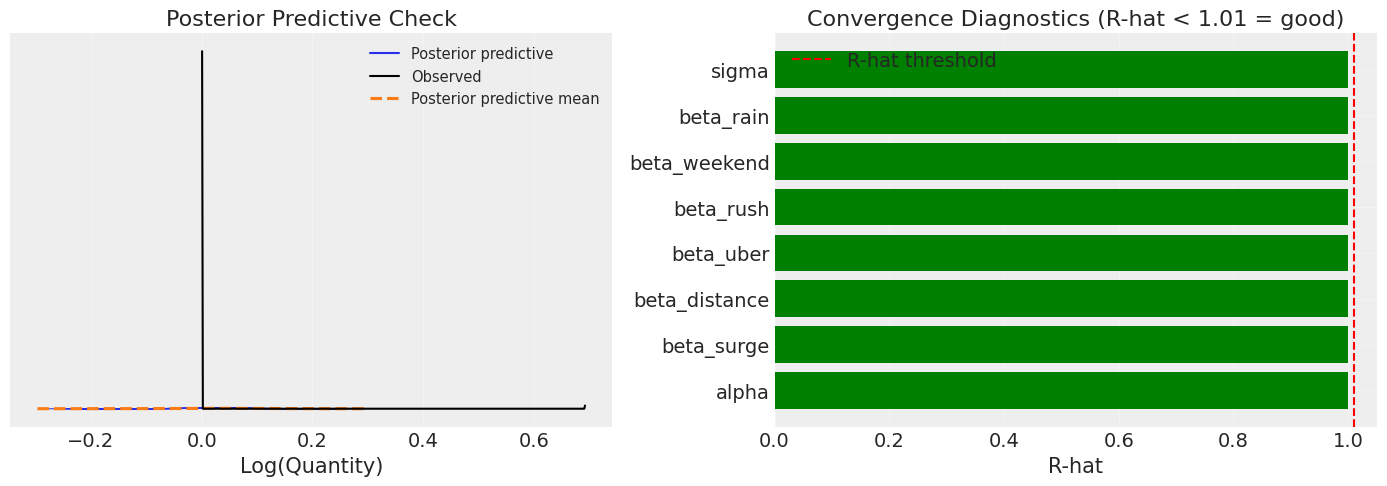

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPC
ax = axes[0]
az.plot_ppc(ppc, observed=True, ax=ax, num_pp_samples=100)
ax.set_title('Posterior Predictive Check')
ax.set_xlabel('Log(Quantity)')

# R-hat values
ax = axes[1]
rhat_values = az.rhat(trace_full)
var_names = list(rhat_values.data_vars.keys())
rhat_vals = [float(rhat_values[v].values) for v in var_names]
colors = ['green' if r < 1.01 else 'red' for r in rhat_vals]
ax.barh(var_names, rhat_vals, color=colors)
ax.axvline(x=1.01, color='red', linestyle='--', label='R-hat threshold')
ax.set_xlabel('R-hat')
ax.set_title('Convergence Diagnostics (R-hat < 1.01 = good)')
ax.legend()

plt.tight_layout()
plt.show()

## 7. Limitations & Next Steps

### Limitations of This Analysis

1. **Endogeneity**: Surge is triggered by demand, creating bias. We've controlled for observables but unobserved confounders remain.

2. **Demand proxy**: We use ride counts as demand, but this is realized demand (already filtered by prices). True demand curve is steeper.

3. **Static model**: We assume elasticity is constant. In reality, it likely varies with demand intensity.

4. **No long-term effects**: We don't capture customer churn from repeated surge exposure.

### Next Steps

**Notebook 03 (Contextual Bandits)**: Use these elasticity estimates to design a bandit that learns optimal surge levels in real-time, balancing exploration and exploitation.

**Notebook 04 (Reinforcement Learning)**: Model the long-term effects of pricing decisions, including customer retention and market dynamics.

In [22]:
# Save key results for next notebooks
results = {
    'mean_elasticity': float(elasticity_original.mean()),
    'elasticity_hdi_low': float(np.percentile(elasticity_original, 3)),
    'elasticity_hdi_high': float(np.percentile(elasticity_original, 97)),
    'elasticity_std': float(elasticity_original.std()),
}

import json
output_path = Path.cwd().parent / 'outputs' / 'elasticity_results.json'
output_path.parent.mkdir(parents=True, exist_ok=True)
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved elasticity results to {output_path}")
print(json.dumps(results, indent=2))

Saved elasticity results to /home/arnaud/projets/dynamic-pricing-engine/outputs/elasticity_results.json
{
  "mean_elasticity": -0.006874542778519224,
  "elasticity_hdi_low": -0.02922591319027726,
  "elasticity_hdi_high": 0.015579701879119919,
  "elasticity_std": 0.011997299475642667
}


---

**Next**: Notebook 03 - Contextual Bandits for Real-time Price Optimization